In [51]:
import gym
gym.logger.set_level(40)
import envs
import autograd.numpy as np
from autograd import grad, jacobian
import matplotlib.pyplot as plt
from controller import MPC
from stable_koopman import StableKoopman
import argparse
import random

In [52]:
env_name = "CartPoleContinuous-v0"
env = gym.make(env_name)
train_epi = 50
max_step = 2000

In [53]:
def basis(state, action):
    action = action[0]
    extra_basis = np.array([np.sin(state[2]), action*np.cos(state[2])])
    psi = np.hstack((state, extra_basis))
    return psi

print(basis(np.zeros(4), [0]))

[0. 0. 0. 0. 0. 0.]


In [54]:
num_state = env.observation_space.shape[0]
num_basis = num_state + 3
SK = StableKoopman()

In [55]:
X = []
Y = []
U = []

for i in range(train_epi):
    state = env.reset(np.array([0.0,0.0,0.0,0.0]))
    step = 0
    
    while step < max_step:
        action = env.action_space.sample()
        new_state, _, _, _ = env.step(action)

        X.append(basis(state, action))
        Y.append(basis(new_state, action))
        U.append(action)


        state = new_state
        step += 1

X = np.array(X).transpose()
Y = np.array(Y).transpose()
U = np.array(U).transpose()

print("X shape:",X.shape)
print("Y shape:",Y.shape)
print("U shape:",U.shape)

X shape: (6, 100000)
Y shape: (6, 100000)
U shape: (1, 100000)


In [56]:
params = { 
    'log_memory' : 'store_true',
    'conjugate_gradient': 'store_true',
    'step_size_factor': 5,
    'fgm_max_iter': 20,
    'alpha' : 0.5,
    'stability_relaxation': 0.,
    'time_limit' : 1800,
    'eps' : 1e-12
}

A,B, mem = SK.learn_stable_soc_with_inputs(X=X, Y=Y, U=U, **params)
print(A.shape)
print(B.shape)

(6, 6)
(6, 1)


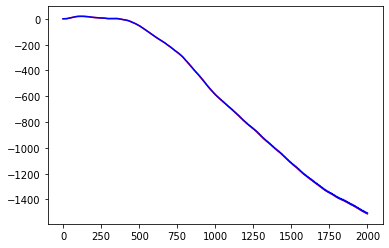

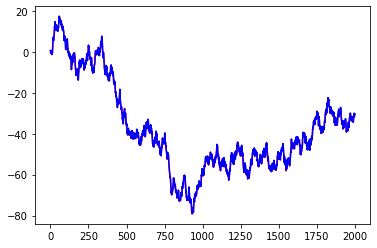

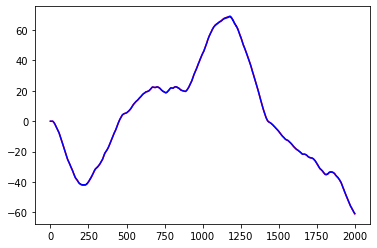

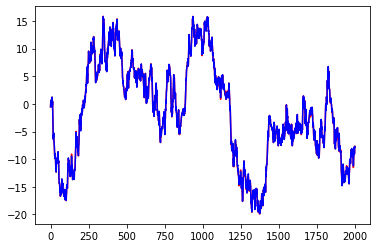

In [60]:
state = env.reset(np.array([1.0,0.0,0.0,0.0]))
predict_state = state.copy()
step = 0
predict_arr = []
actual_arr = []


freq = 2000
while step < max_step:
    action = env.action_space.sample()

    #propagate actual state
    new_state, _, _, _ = env.step(action)
    actual_arr.append(new_state)

    if step % freq == 0:
        predict_state = state

    #propagate predicted state
    new_predict_state = (A @ basis(predict_state, action).reshape(-1,1) + B @ action.reshape(-1,1)).flatten()[:4]
    predict_arr.append(new_predict_state)

    #update
    state = new_state
    predict_state = new_predict_state
    step += 1
    
    
actual_arr = np.array(actual_arr)
predict_arr = np.array(predict_arr)

for s in range(4):
    plt.plot(np.linspace(0,max_step, max_step), actual_arr[:,s], color='red')
    plt.plot(np.linspace(0,max_step, max_step), predict_arr[:,s], color='blue')

    plt.show()

end


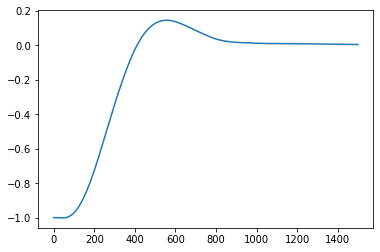

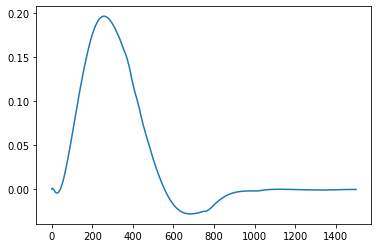

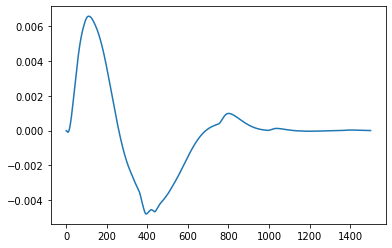

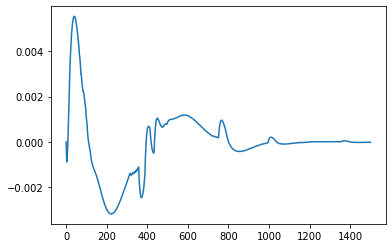

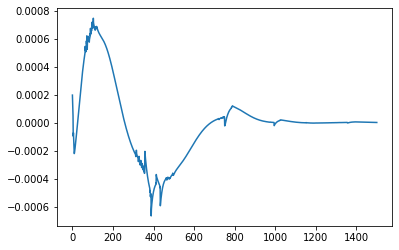

In [14]:
controller = MPC(50, km.get_K_h_T(), basis, env.dt)
state = env.reset(np.array([-1.0,0.0,0.0,0.0]))
action = np.array([0.0])
max_step = 1500

step = 0
traj_arr = []
action_arr = []

while step < max_step:

    traj_arr.append(state)
    action = controller(state, 0.001, 5, 1.0)#controller(state)#controller(state, 1.0)
    action_arr.append(action)
    new_state, _, _, _ = env.step(action)
    

    state = new_state
    step += 1
    
print('end')

traj_arr = np.array(traj_arr)
action_arr = np.array(action_arr)

t_step = np.linspace(0,max_step,max_step)
for s in range(4):
    plt.plot(t_step, traj_arr[:,s])
    plt.show()

plt.plot(t_step, action_arr)
plt.show()